In [1]:
# Tested on python 3.6.4 
%matplotlib inline

import numpy as np # 1.13.3
from scipy.integrate import odeint # 1.0.0
import scipy.optimize as op
import scipy.stats as stats
import matplotlib.pyplot as plt # 2.1.1
from matplotlib.ticker import AutoMinorLocator
from matplotlib.ticker import MaxNLocator

import pandas as pd # 0.22.0
import emcee # 2.2.1
import corner # 2.0.1
import progressbar # 3.34.3
import seaborn as sns # 0.8.1
from cycler import cycler # 0.10.0

from helper import * # helper.py

print('emcee version', emcee.__version__)

# Directories defined here 
DIR_DATA = './data/'
DIR_PLOTS = './plots/'
DIR_OUT = './output/'

emcee version 2.2.1


This jupyter notebook defines the thermodynamic model used in the 2018 Swank et al. paper and carries out MCMC sampling for parameter inference using the [emcee](http://dfm.io/emcee/current/) package. The code in this notebook requires the following data files, which are located in `DIR_DATA`:

    distance_chip_8A.csv

The results are used to generate the helix-cooperativity results shown in Figure 5. Plots are written into `DIR_PLOTS` while MCMC samples are written into `DIR_OUT`. Warning: sample files may be very large.

# Helix-cooperativity effect: thermodynamic model

## 1. Define model

In [2]:
def modelhelix(A,C0,r1,r2,E1,E2,E12):
    Freg_c = (1+r1*np.exp(-E1)+r2*np.exp(-E2)+r1*r2*np.exp(-E1-E2-E12))/(1+r1+r2+r1*r2*np.exp(-E12))
    Freg_nc = (1+r1*np.exp(-E1)+r2*np.exp(-E2)+r1*r2*np.exp(-E1-E2))/(1+r1+r2+r1*r2)
    p_c = A/(1+C0/Freg_c)   
    p_nc = A/(1+C0/Freg_nc)   
    p_0 = A/1+C0
    return (p_c,p_nc,p_0)

# r1, r2, E2, A, and C0 have been previously determined
# E1 and E12 have a distance dependence
# E12 has a phase dependence

def helixdist(x,E10,E120,lamb,phi):
    E1 = E10*np.exp(-x*lamb)
    E12 = E120*np.exp(-x*lamb)*(1+np.cos(np.pi*2/10.5*x-phi))
    return(E1,E12)

# There are 9 parameters of which we should be able to use previous values for 7

def showmodel(y0,lamb,phi): # Look at model behaviour
    
    # Fixed parameters from dose response experiments
    A=y0
    C0=0.66070446353476231
    r1=1/0.16746036268850761
    r2=1/0.0082708295083317035
    E10=1.4349132332094823
    E2=1.3110190282670602
    E120=-3.4804403863425248

    E1,E12=helixdist(x,E10,E120,lamb,phi)
    p_c,p_nc,p_0=modelhelix(A,C0,r1,r2,E1,E2,E12)

    plt.plot(x,p_0,'o-');
    plt.plot(x,p_c,'o-');
    plt.plot(x,p_nc,'o-');
    plt.show()

    plt.plot(x,p_0/p_c,'o-');
    plt.plot(x,p_0/p_nc,'o-');
    plt.show()

# Model uses parameters from dose response experiment for BCBPDZ-ADDL. The parameter A is taken to be 
# the unrepressed state for each measurement. The only free parameters are the exponential decay of 
# distance lambda, and the phase shift phi. The helical pitch of 10.5bp/turn is fixed.

# Uncomment below to show data and model
# limit = 30
# df3=pd.read_csv('data/distance_chip_8A.csv',delimiter=',')
# x=df3['Spacing'][:limit]
# y0=df3['Control'][:limit]
# showmodel(y0,lamb=0.1,phi=0) 

## 2. Read data

In [3]:
# Read data
df3 = pd.read_csv(DIR_DATA+'distance_chip_8A.csv',delimiter=',')

FRC = df3['Control']/df3['Cognate']
FRCe = np.sqrt((df3['Cont_err']/df3['Control'])**2+(df3['C_err']/df3['Control'])**2)*FRC

FRNC = df3['Control']/df3['Non-cognate']
FRNCe = np.sqrt((df3['Cont_err']/df3['Control'])**2+(df3['NC_err']/df3['Non-cognate'])**2)*FRC

limit = df3['Spacing'].shape[0] # 30

x = df3['Spacing'][:limit]
y0 = df3['Control'][:limit]
y1 = FRC[:limit]
yerr1 = FRCe[:limit]
y2 = FRNC[:limit]
yerr2 = FRNCe[:limit]

## 3. Define functions and carry out MCMC sampling

In [4]:
# Define MCMC functions

def normalprior(param,mu,sigma):
    return np.log( 1.0 / (np.sqrt(2*np.pi)*sigma) ) - 0.5*(param - mu)**2/sigma**2

def lnlike(theta,x,y0,y1,yerr1,y2,yerr2):
    lnlamb,phi,lnR0 = theta
    lamb = np.exp(lnlamb)
    R0 = np.exp(lnR0)
    
    # Fixed parameters from dose response experiments   
    A=y0
    C0=0.66210928096297694
    r1=R0/0.16560747167723452
    r2=R0/0.0082434759698867578
    E10=1.4324039293504833
    E2=1.3154743220886698
    E120=-3.462378690300405
    
    E1,E12 = helixdist(x,E10,E120,lamb,phi)
    
    p_c,p_nc,p_0 = modelhelix(A,C0,r1,r2,E1,E2,E12)
    FRC_mod = p_0/p_c
    FRNC_mod = p_0/p_nc
   
    inv_sigma2_1 = 1/(yerr1**2)
    inv_sigma2_2 = 1/(yerr2**2)
    X1 = np.sum((FRC_mod-y1)**2*inv_sigma2_1-np.log(np.pi*2*inv_sigma2_1))
    X2 = np.sum((FRNC_mod-y2)**2*inv_sigma2_2-np.log(np.pi*2*inv_sigma2_2))
    return -0.5*(X1+X2)

def lnprior(theta,x,y0,y1,yerr1,y2,yerr2):
    lnlamb1,phi,lnR0=theta
    if not (-np.pi<phi<np.pi): 
        return -np.inf # Hard-cutoff for positive value constraint
    
    log_Pr1 = normalprior(lnlamb1,np.log(0.2),2)    
    log_Pr2 = normalprior(phi,0,np.pi*2)
    log_Pr3 = normalprior(lnR0,np.log(1),3)

    return log_Pr1 + log_Pr2 + log_Pr3 

def lnprob(theta,x,y0,y1,yerr1,y2,yerr2):
    lp = lnprior(theta,x,y0,y1,yerr1,y2,yerr2)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta,x,y0,y1,yerr1,y2,yerr2)

def MCMC(x,y0,y1,yerr1,y2,yerr2,ZFname,
         parameternames,nwalkers,ndim,iterations,pos,tburn,threads,
        DIR_OUT,DIR_PLOTS):
    
    # Initialise MCMC
    sampler = emcee.EnsembleSampler(nwalkers,ndim,lnprob,a=2,
                                  args=(x,y0,y1,yerr1,y2,yerr2),threads=threads)

    bar = progressbar.ProgressBar(max_value=iterations)
    # Run MCMC
    for i, result in enumerate(sampler.sample(pos, iterations=iterations)):
        bar.update(i)

    samples = sampler.chain[:,:,:].reshape((-1,ndim)) # shape = (nsteps*nwalkers, ndim)
    samplesnoburn = sampler.chain[:,tburn:,:].reshape((-1,ndim)) # burn-in removed

    df = pd.DataFrame(samples)
    # Uncomment following line to save
    df.to_csv(path_or_buf=DIR_OUT+'samplesout_'+ZFname+'.csv',sep=',') 

    plottraces2(samples,parameternames,nwalkers,iterations,ZFname,DIR_PLOTS)
    fig = corner.corner(samplesnoburn, labels=parameternames, 
                      show_titles=True,title_fmt=None, 
                      title_kwargs={"fontsize": 12},
                      label_kwargs={"fontsize": 16},
                      plot_contours=True,use_math_text=True)
    fig.savefig(DIR_PLOTS+ZFname+'triangle.png')
    return(samplesnoburn)

 99% (9999 of 10000) |################### | Elapsed Time: 0:28:23 ETA:  0:00:00

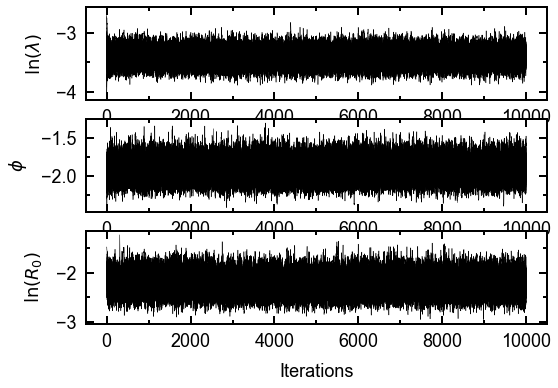

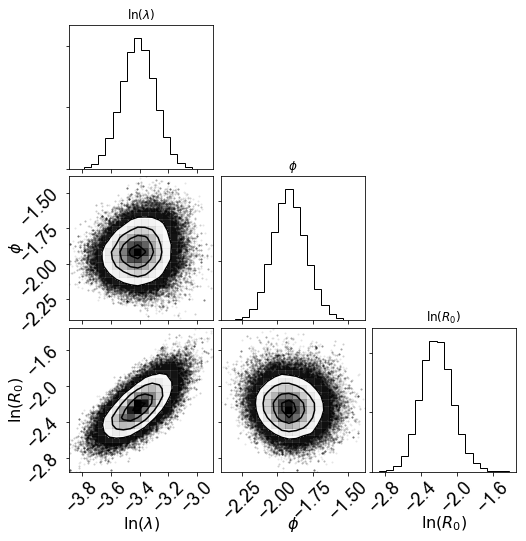

In [5]:
# Setup MCMC and run
np.random.seed(0) # For reproducible outputs
parameternames = ["$\ln(\lambda)$","$\phi$","$\ln(R_0)$"]
nwalkers,ndim,iterations,tburn,threads=50,3,10000,5000,2 # Set threads correctly for parallelisation
pos = [np.array([
    -3.28333987 *(1+1/10*np.random.randn()),
    -1.92874554*(1+1/10*np.random.randn()),
    -1.97663578*(1+1/10*np.random.randn())
]) for i in range(nwalkers)] # Initialise walkers 

# Run MCMC and plot
samples_noburn = MCMC(x,y0,y1,yerr1,y2,yerr2,'helix',
                    parameternames,nwalkers,ndim,iterations,pos,tburn,threads,
                   DIR_OUT,DIR_PLOTS)

## 4. Plot fit results

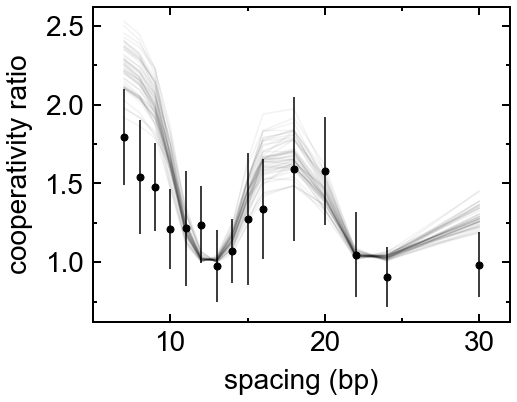

In [6]:
# Plot ensemble of models
numberofmodeltraces = 50

plottraces3L(df3,x,y0,y1,yerr1,y2,yerr2,'helix_ensemble_levels',DIR_PLOTS,
             helixdist,modelhelix,
             numberofmodeltraces=50,samples=samples_noburn,quant=None)
plottraces3FR(x,y0,y1,yerr1,y2,yerr2,'helix_ensemble_FR',DIR_PLOTS,
              helixdist,modelhelix,
              numberofmodeltraces=50,samples=samples_noburn,quant=None)
plottraces3CR(x,y0,y1,yerr1,y2,yerr2,'helix_ensemble_CR',DIR_PLOTS,
              helixdist,modelhelix,
              numberofmodeltraces=50,samples=samples_noburn,quant=None)

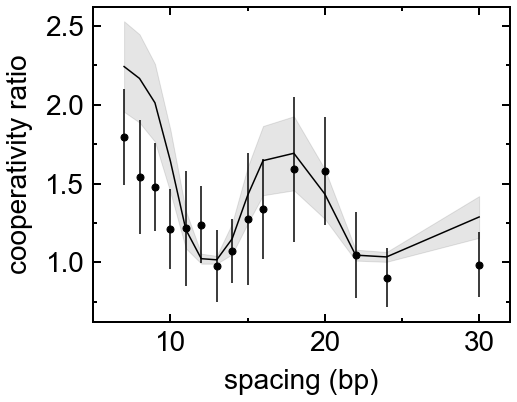

In [7]:
# Construct intervals and plot max likelihood and shaded intervals
np.random.seed(0) # For reproducible outputs            
xmod = x
numberofmodeltraces = 1000

ypred1 = np.zeros((len(xmod),numberofmodeltraces))
ypred2 = np.zeros((len(xmod),numberofmodeltraces))
ypred3 = np.zeros((len(xmod),numberofmodeltraces))
ypred4 = np.zeros((len(xmod),numberofmodeltraces))
ypred5 = np.zeros((len(xmod),numberofmodeltraces))

i=0
for lnlamb,phi,lnR0 in samples_noburn[np.random.randint(len(samples_noburn), size=numberofmodeltraces)]:    
    lamb = np.exp(lnlamb)
    R0 = np.exp(lnR0)
    
    # Fixed parameters from dose response experiments
    A=y0
    C0=0.66070446353476231
    r1=R0/0.16746036268850761
    r2=R0/0.0082708295083317035
    E10=1.4349132332094823
    E2=1.3110190282670602
    E120=-3.4804403863425248

    E1,E12 = helixdist(xmod,E10,E120,lamb,phi)
    p_c,p_nc,p_0 = modelhelix(y0,C0,r1,r2,E1,E2,E12)
                    
    ypred1[:,i] = p_0/p_c
    ypred2[:,i] = p_0/p_nc
    ypred3[:,i] = p_nc/p_c
    ypred4[:,i] = p_c
    ypred5[:,i] = p_nc
    i+=1

# 2-sigma distributions
quant1 = [np.mean(ypred1,axis=1)-2*np.std(ypred1,axis=1),
          np.mean(ypred1,axis=1),
          np.mean(ypred1,axis=1)+2*np.std(ypred1,axis=1)]
quant2 = [np.mean(ypred2,axis=1)-2*np.std(ypred2,axis=1),
          np.mean(ypred2,axis=1),
          np.mean(ypred2,axis=1)+2*np.std(ypred2,axis=1)]
quant3 = [np.mean(ypred3,axis=1)-2*np.std(ypred3,axis=1),
          np.mean(ypred3,axis=1),
          np.mean(ypred3,axis=1)+2*np.std(ypred3,axis=1)]
quant4 = [np.mean(ypred4,axis=1)-2*np.std(ypred4,axis=1),
          np.mean(ypred4,axis=1),
          np.mean(ypred4,axis=1)+2*np.std(ypred4,axis=1)]
quant5 = [np.mean(ypred5,axis=1)-2*np.std(ypred5,axis=1),
          np.mean(ypred5,axis=1),
          np.mean(ypred5,axis=1)+2*np.std(ypred5,axis=1)]

quant = [quant1,quant2,quant3,quant4,quant5]

plottraces3L(df3,x,y0,y1,yerr1,y2,yerr2,'helix_maxlike_L',DIR_PLOTS,
             helixdist,modelhelix,
             numberofmodeltraces=50,samples=0,quant=quant)
plottraces3FR(x,y0,y1,yerr1,y2,yerr2,'helix_maxlike_FR',DIR_PLOTS,
              helixdist,modelhelix,
              numberofmodeltraces=50,samples=0,quant=quant)
plottraces3CR(x,y0,y1,yerr1,y2,yerr2,'helix_maxlike_CR',DIR_PLOTS,
              helixdist,modelhelix,
              numberofmodeltraces=50,samples=0,quant=quant)

0

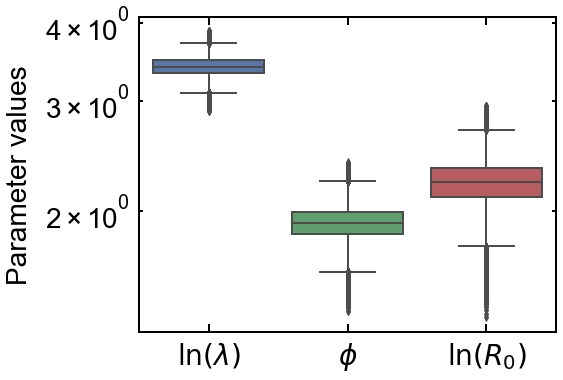

In [8]:
parameternames = ["$\ln(\lambda)$","$\phi$","$\ln(R_0)$"]
nwalkers = 50
iterations = 10000
tburn = 5000
ZFname = 'helix'
boxplots(ZFname,parameternames,nwalkers,iterations,tburn,DIR_PLOTS,DIR_OUT)